# Dataset columns - first three columns are userId, productId, and ratings and the fourth column is
timestamp. You can discard the timestamp column as in this case you may not need to use it.
Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has
several datasets. For this case study, we are using the Electronics dataset.
Please do the analysis based on steps( 1 to 8) as given below -
Steps -
1. Read and explore the given dataset. ( Rename column/add headers, plot histograms,
find data characteristics)
2. Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the
users only who has given 50 or more number of ratings )
3. Build Popularity Recommender model.
4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)
5. Build Collaborative Filtering model.
6. Evaluate the above model. ( Once the model is trained on the training data, it can be
used to compute the error (like RMSE) on predictions made on the test data.) You can
also use a different method to evaluate the models.
7. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to
each user based on his/her habits, we will recommend 5 new products.
#8. Summarise your insights.

In [66]:
#Importing all necessary libraries required for the resolution of this solution
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from surprise import SVD,KNNWithMeans,accuracy,Dataset,Reader
from surprise.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score,make_scorer

In [2]:
#Reading the data and setting the column names
columns=["user_id","product_id","rating","date"]
df_electronics=pd.read_csv('ratings_Electronics.csv',names=columns)

In [3]:
df_electronics.head()

,user_id,product_id,rating,date
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [4]:
#checking the shape and hence checking the total number of data items in the dataframe
df_electronics.shape

(7824482, 4)

In [5]:
#Checking if there is "NA" in the data
df_electronics.isna().sum()

user_id       0
product_id    0
rating        0
date          0
dtype: int64

In [6]:
#Checking if there is "NULL" in the data
df_electronics.isnull().sum()

user_id       0
product_id    0
rating        0
date          0
dtype: int64

In [7]:
#Removing date column from the dataframe
df_electronics=df_electronics.drop('date',axis=1)

In [8]:
df_electronics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
user_id       object
product_id    object
rating        float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [9]:
#Checking various statistics of the numerical column in the data frame.
df_electronics.describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


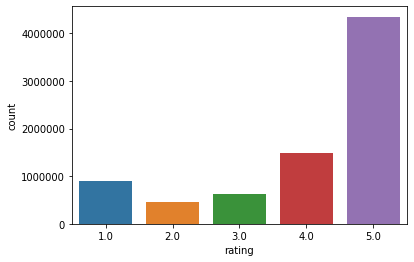

In [10]:
#Printing histogram for ratings , basically this depicts a frequency of each rating in the total dataset
sns.countplot(df_electronics['rating'])

# Subsetting a dataset

In [11]:
#Before subsetting the data, unique elements are :-
print("Total Unique users in data are {}".format(len(df_electronics['user_id'].unique().tolist())))
print("Total Unique product in data are {}".format(len(df_electronics['product_id'].unique().tolist())))

Total Unique users in data are 4201696
Total Unique product in data are 476002


In [12]:
#checking number of ratings provided by one user
df_electronics[df_electronics['user_id']=='AZZYW4YOE1B6E'].count()

user_id       35
product_id    35
rating        35
dtype: int64

In [13]:
#checking number of ratings provided by each user
df_electronics['user_id'].value_counts()[0:,]

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
ARBKYIVNYWK3C     296
A22CW0ZHY3NJH8    292
A38RMU1Y5TDP9     282
A3EXWV8FNSSFL6    282
A3LGT6UZL99IW1    279
A2NOW4U7W3F7RI    277
A23GFTVIETX7DS    270
A3PD8JD9L4WEII    266
A17BUUBOU0598B    261
A3AYSYSLHU26U9    257
A2XRMQA6PJ5ZJ8    253
A12DQZKRKTNF5E    252
A231WM2Z2JL0U3    252
A1UQBFCERIP7VJ    247
AGVWTYW0ULXHT     244
A203OCQQ12MAVT    240
AEJAGHLC675A7     239
A2NYK9KWFMJV4Y    238
A3A4ZAIBQWKOZS    236
A3CW0ZLUO5X2B1    227
                 ... 
AXY0DG6GMBL23       1
A1A9166YMOCSVQ      1
A2MJ0V9PKJYWHW      1
A1WEVBZYEUH6L7      1
A1ASM4SWBLTEQC      1
A8QXFSQ4TIIT4       1
A34SPVGAYJ1JSU      1
A1OU01F5WTX069      1
A3QHA1SUTV3ZPH      1
A2Q3M2MHCC56VE      1
A2TYNGC62250QZ      1
A3JIAS9LS8PT9U      1
AYV2321B2ESST       1
A3PHUYGOO936ZY      1
A1VDFGNMJY

In [14]:
#collecting a matrix of user mapping with number of ratings provided in an array
electronics=df_electronics['user_id'].value_counts()

In [15]:
#subsetting the data where user has provided more than 50 ratings
electronics_subset = df_electronics[df_electronics['user_id'].isin(electronics[electronics>50].index)]

In [16]:
#Checking the shape of subsetted data
electronics_subset.shape

(122171, 3)

# Popularity based Model - Top 50 items based on rating

In [17]:
#Printing least 10 product rating 
df_electronics.groupby('product_id')['rating'].mean().sort_values(ascending=False).tail(10)
#df_electronics.groupby('product_id')['rating'].mean().head(10)

product_id
B0021O5FFI    1.0
B0000AC8A2    1.0
B0021NN74U    1.0
B0021MI8EA    1.0
B008LT2WZI    1.0
B008LT3D6A    1.0
B00J5ARFNG    1.0
B00FAVJXUW    1.0
B0021HEJKC    1.0
B008ANKWMA    1.0
Name: rating, dtype: float64

In [18]:
#Printing highest 10 product rating 
df_electronics.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(10)

product_id
BT008V9J9U    5.0
B0058PPK8Y    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
B0058OHGX2    5.0
B0058O9OR8    5.0
B0058O6O8K    5.0
B0058O6J3A    5.0
B0058O6EXA    5.0
B0058O0CMO    5.0
Name: rating, dtype: float64

In [19]:
#prinitng products in descending order with most rated recieved product as first item
df_electronics.groupby('product_id')['rating'].count().sort_values(ascending=False).head(10)
#df_electronics.groupby('product_id')['rating'].count().head(10)

product_id
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
B003ELYQGG    11617
B003ES5ZUU    10276
B007R5YDYA     9907
B00622AG6S     9823
B0002L5R78     9487
Name: rating, dtype: int64

In [20]:
product_rating_mean_count=pd.DataFrame(df_electronics.groupby('product_id')['rating'].mean())

In [21]:
product_rating_mean_count.head(5)

,rating
product_id,
0132793040,5.000000
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852


In [22]:
product_rating_mean_count['rating_count']=df_electronics.groupby('product_id')['rating'].count()

In [23]:
product_rating_mean_count.head()

,rating,rating_count
product_id,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27


In [24]:
product_rating_mean_count.shape

(476002, 2)

In [25]:
product_rating_mean_count.head(15)

,rating,rating_count
product_id,,
0132793040,5.000000,1
0321732944,5.000000,1
0439886341,1.666667,3
0511189877,4.500000,6
0528881469,2.851852,27
0558835155,3.000000,1
059400232X,5.000000,3
0594012015,2.000000,8
0594017343,1.000000,1


# Splitiing Data

# Collaberative Filtering on user and using Matrix factorization with SVD

In [26]:
#dataPreparation, since we have to surprise library , hence converting data into surprise format. 
#All operations are performed on subseted data
preparedata={"userid" : list(electronics_subset.user_id),
            "productid" : list(electronics_subset.product_id),
            "rating" : list(electronics_subset.rating)}

In [27]:
new_dataframe=pd.DataFrame.from_dict(preparedata)

In [28]:
#reader=Reader(rating_scale=(1, 5))
reader=Reader(line_format='user item rating',rating_scale=(1, 5))
data=Dataset.load_from_df(new_dataframe,reader)

In [29]:
#splitiing the data into train and test
train,test=train_test_split(data,test_size=0.2)

In [30]:
train.n_users

1466

In [31]:
train.n_items

40895

In [32]:
#User based collabrative filtering.
algo=KNNWithMeans(k=10,sim_options={'name': 'pearson_baseline', 'user_based': True})

In [33]:
algo.fit(train)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
pred=algo.test(test)

In [35]:
pred

[Prediction(uid='A17HMM1M7T9PJ1', iid='B0030D5KMW', r_ui=4.0, est=4.260589751984939, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A24P4E3RJ6AX94', iid='B001TH7GUA', r_ui=5.0, est=5, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A12R3YGEHW7D8G', iid='B004CAHTCQ', r_ui=5.0, est=4.188667563812644, details={'actual_k': 2, 'was_impossible': False}),
 Prediction(uid='A2LB4FLRZG6CUV', iid='B0083E5GUE', r_ui=4.0, est=4.260589751984939, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'}),
 Prediction(uid='A1Y85GQ09Y95JL', iid='B0092KRAVQ', r_ui=5.0, est=3.106382978723404, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B007XOQ3BQ', r_ui=3.0, est=4.419354838709677, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='A1LD5SE8IZ1H70', iid='B002ZV51DI', r_ui=4.0, est=4.516129032258065, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(ui

In [42]:
# RMSE with User Collabrative Method
print("Error with User collabrative Method {}".format(accuracy.rmse(pred,verbose=True)))

RMSE: 1.0495
Error with User collabrative Method 1.049535675324967


In [37]:
#Putting a definiton of a function which further will be used for getting top rated products
def get_top_n(pred, n):
    top_n=defaultdict(list)
    for uid,iid,rui,est,_ in pred:
        top_n[uid].append((iid,est))
        
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

In [38]:
#Getting top 5 RAted recommended product
top_n = get_top_n(pred, n=5)

In [39]:
top_n

defaultdict(list,
            {'A17HMM1M7T9PJ1': [('B00HFRWWAM', 4.82101043717794),
              ('B000U5TUWE', 4.790230248176434),
              ('B00DQZOD8Q', 4.659226290938992),
              ('B00109Y2DQ', 4.449159600285195),
              ('B001OQC0IO', 4.386286860518011)],
             'A24P4E3RJ6AX94': [('B001TH7GUA', 5),
              ('B00E3W15P0', 5),
              ('B001S4OTS6', 4.962483124461408),
              ('B00DTZYHX4', 4.880726461971604),
              ('B000067RT6', 4.688790340975612)],
             'A12R3YGEHW7D8G': [('B002WE4HE2', 4.606935436741199),
              ('B0099SMFP2', 4.366233766233766),
              ('B0052JCM6Y', 4.314285714285714),
              ('B00603RU9A', 4.314285714285714),
              ('B00HJNX0XU', 4.314285714285714)],
             'A2LB4FLRZG6CUV': [('B00IX2VGFA', 4.837620977748366),
              ('B004YLCE2S', 4.689664502164502),
              ('B0074BW614', 4.552414039289692),
              ('B006GWO5WK', 4.332426594906831),
         

# RMSE with SVD

In [72]:
svd_algo=SVD(n_factors=10,reg_all=0.01)

In [73]:
svd_algo.fit(train)

In [74]:
pred_svd=svd_algo.test(test)

In [75]:
pred_svd

[Prediction(uid='A17HMM1M7T9PJ1', iid='B0030D5KMW', r_ui=4.0, est=4.239452492276637, details={'was_impossible': False}),
 Prediction(uid='A24P4E3RJ6AX94', iid='B001TH7GUA', r_ui=5.0, est=4.80865705439089, details={'was_impossible': False}),
 Prediction(uid='A12R3YGEHW7D8G', iid='B004CAHTCQ', r_ui=5.0, est=4.429295682839151, details={'was_impossible': False}),
 Prediction(uid='A2LB4FLRZG6CUV', iid='B0083E5GUE', r_ui=4.0, est=4.172097300060428, details={'was_impossible': False}),
 Prediction(uid='A1Y85GQ09Y95JL', iid='B0092KRAVQ', r_ui=5.0, est=3.47609800289992, details={'was_impossible': False}),
 Prediction(uid='A30XZK10EZN9V4', iid='B007XOQ3BQ', r_ui=3.0, est=4.379408714367113, details={'was_impossible': False}),
 Prediction(uid='A1LD5SE8IZ1H70', iid='B002ZV51DI', r_ui=4.0, est=4.315091204773109, details={'was_impossible': False}),
 Prediction(uid='A259MPG6SOL02P', iid='B00004TDN2', r_ui=3.0, est=3.3613486445432295, details={'was_impossible': False}),
 Prediction(uid='AA95DWUI3ODU', i

In [76]:
top_n = get_top_n(pred_svd, n=5)

In [77]:
top_n

defaultdict(list,
            {'A17HMM1M7T9PJ1': [('B00HFRWWAM', 4.563599455014811),
              ('B000U5TUWE', 4.536774808294958),
              ('B0002YE6FY', 4.469393654258616),
              ('B00109Y2DQ', 4.396098454546651),
              ('B003BYIM0W', 4.30515322284298)],
             'A24P4E3RJ6AX94': [('B00E3W15P0', 4.854834875496828),
              ('B001TH7GUA', 4.80865705439089),
              ('B000067RT6', 4.801618086830304),
              ('B00DTZYHX4', 4.742469184593593),
              ('B001S4OTS6', 4.627343530513732)],
             'A12R3YGEHW7D8G': [('B0099SMFP2', 4.5879739819101575),
              ('B002WE4HE2', 4.555899242287436),
              ('B004CAHTCQ', 4.429295682839151),
              ('B00HJNX0XU', 4.287676619239989),
              ('B00137NMMW', 4.240471120113456)],
             'A2LB4FLRZG6CUV': [('B00IX2VGFA', 4.574677940799441),
              ('B000EVSLRO', 4.513684750168397),
              ('B00FISD9DO', 4.382339211780896),
              ('B00G4V0QSK

In [78]:
accuracy.rmse(pred_svd)

RMSE: 0.9655


0.9655209932115316

In [80]:
#print using svd with different parameters
svd_algo=SVD(n_factors=15,reg_all=0.02,n_epochs=30)

In [81]:
svd_algo.fit(train)
pred_svd=svd_algo.test(test)

In [82]:
accuracy.rmse(pred_svd)

RMSE: 0.9667


0.9666625497552801

# Summarise your insights.
1. Based on the RMSE value SVD based collaborative filtering have done a better job, the RMSE value is lesser for SVD based solution.
2. There are many products with 5 rating and no other data to differentiate those products, So all the products with 5 rating and equal correlation have equal chance to recommend.
3. Here its used 'Matrix Factorization' based collaborative filtering. There are other types of collaborative filtering techniques like Clustering, Deep Learning based.
